In [1]:
import numpy as np
import wisps
import wisps.simulations as wispsim
import wisps.simulations.effective_numbers as eff
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from tqdm import tqdm 
import pandas as pd
import matplotlib as mpl
%matplotlib inline

In [2]:
from wisps import drop_nan

In [3]:
baraffe_data=eff.simulation_outputs()["baraffe2003"]
saumon_data=eff.simulation_outputs()["saumon2008"]


In [4]:
import seaborn as sns

In [5]:
cmap_teff=sns.diverging_palette(100, 300, s=80, l=55, n=19, as_cmap=True)

In [6]:
pnts=wisps.OBSERVED_POINTINGS

In [7]:
volumes=[]
dlimits=[]
for pnt in pnts:
    vs=[]
    dls=[]
    for g in wispsim.SPGRID:
        vsx=[]
        for h in wispsim.HS:
            vsx.append((pnt.volumes[h])[g])
        dls.append(pnt.dist_limits[g])
        vs.append(vsx)
    volumes.append(vs)
    dlimits.append(dls)
volumes=np.array(volumes)
dlimits=np.array(dlimits)

In [8]:
galc=SkyCoord([x.coord.galactic for x in pnts])

In [9]:
vls250=volumes[:,0, :,]

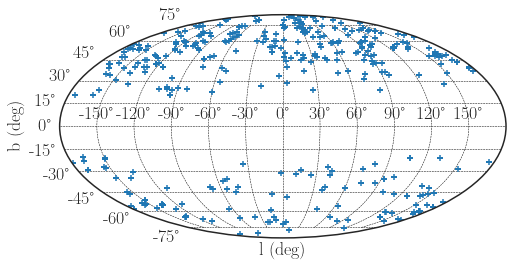

In [10]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection="mollweide")
c=ax.scatter(galc.l.wrap_at(180*u.degree).radian,galc.b.wrap_at(90*u.degree).radian, marker='+', cmap='viridis')
ax.set_xlabel('l (deg)', fontsize=18)
ax.set_ylabel('b (deg)', fontsize=18)
plt.grid()
plt.savefig(wisps.OUTPUT_FIGURES+'/fields_skymap.pdf', bbox_inches='tight')

In [11]:
from matplotlib.colors import Normalize
import seaborn as sns
cnorm=Normalize(wispsim.HS[0]/100, wispsim.HS[-1]/100)

In [12]:
from scipy import integrate

In [13]:
volume_fx=np.vectorize(wispsim.custom_volume)

In [14]:
import seaborn as sns
cmap= sns.cubehelix_palette(light=1, as_cmap=True)

7it [00:01,  4.56it/s]


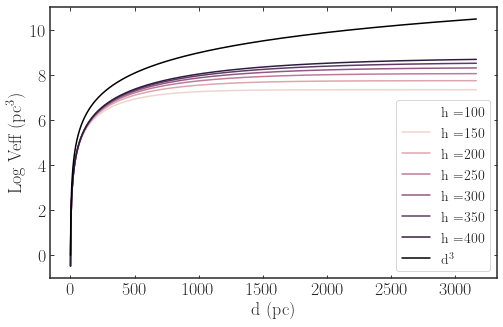

In [15]:
ds=np.logspace(0, 3.5, 1000)
fig, ax=plt.subplots(figsize=(8, 5))
for idx, h in tqdm(enumerate(wispsim.HS)):
    plt.plot(ds, np.log10(volume_fx(0.,np.pi/4, 0, ds,h)), color=cmap(cnorm(h/100)), label=r'h ={}'.format(h))
plt.plot(ds, np.log10(ds**3), c='k', label=r'd$^3$')
plt.ylabel(r'Log Veff (pc$^3$)', fontsize=18)
plt.xlabel('d (pc)', fontsize=18)
plt.legend(fontsize=14)

In [16]:
vsunif=np.nansum((dlimits[:, :,0])**3-(dlimits[:, :,1])**3, axis=0)*4.1*(u.arcmin**2).to(u.radian**2)

In [17]:
VOLUMES=np.nansum(volumes.T, axis=2)*4.1*(u.arcmin**2).to(u.radian**2)

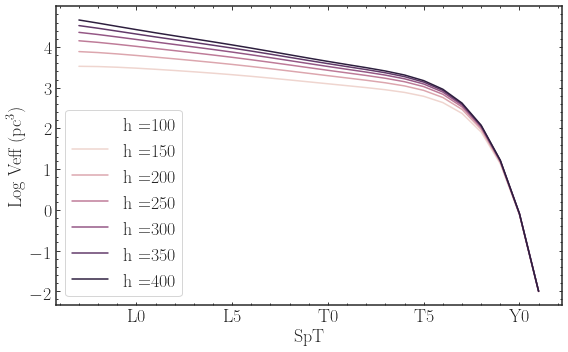

In [18]:
fig, ax=plt.subplots(figsize=(8, 5))
for idx, h in enumerate(wispsim.HS):
    plt.plot(wispsim.SPGRID, np.log10(VOLUMES[idx]), color=cmap(cnorm(h/100)), label=r'h ={}'.format(h))

#plt.plot(wispsim.SPGRID, np.log10(vsunif), label=r'd$^3$' )
plt.ylabel(r'Log Veff (pc$^3$)', fontsize=18)
plt.xlabel('SpT', fontsize=18)
plt.legend(fontsize=18)

plt.minorticks_on()

plt.tight_layout()
ax.set_xticks([20, 25, 30, 35, 40])
ax.set_xticklabels(['L0', 'L5', 'T0', 'T5', 'Y0'])

plt.savefig(wisps.OUTPUT_FIGURES+'/simulation_volumes.pdf', bbox_inches='tight')

In [19]:
cum_volumes=np.cumsum(volumes, axis=1)
cum_volumes.shape

(533, 25, 7)

In [20]:
np.nansum((cum_volumes[:, :, 0]), axis=1).shape

(533,)

In [21]:
steps=np.arange(533)

In [22]:
wispsim.SPGRID

array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41])

In [23]:
import splat

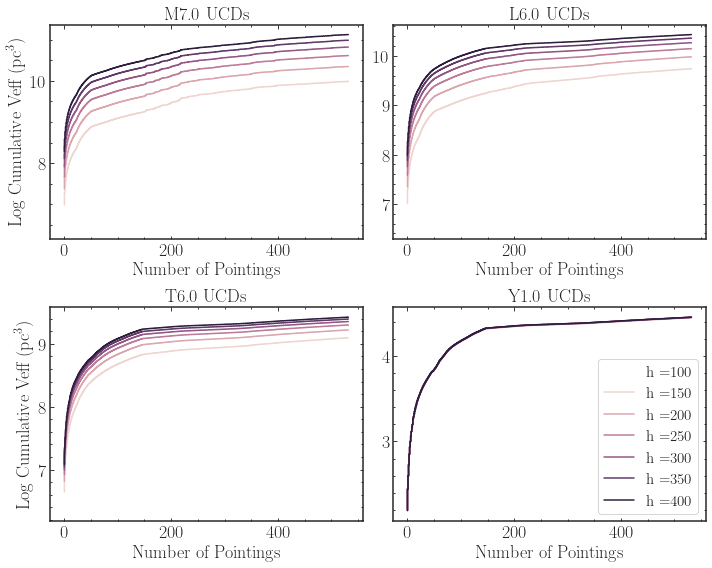

In [24]:
fig, ((ax, ax1), (ax2, ax3))=plt.subplots(figsize=(10, 8), ncols=2, nrows=2)
for idx, h in enumerate(wispsim.HS):
    ax.step(steps, np.log10(np.cumsum(volumes[:, 0, idx])), color=cmap(cnorm(h/100)))
    ax1.step(steps, np.log10(np.cumsum(volumes[:, 9, idx])), color=cmap(cnorm(h/100)))
    ax2.step(steps, np.log10(np.cumsum(volumes[:,-6 , idx])), color=cmap(cnorm(h/100)))
    ax3.step(steps, np.log10(np.cumsum(volumes[:, -1, idx])), color=cmap(cnorm(h/100)), label=r'h ={}'.format(h))


ax.set_ylabel(r'Log Cumulative Veff (pc$^3$)', fontsize=18)
ax2.set_ylabel(r'Log Cumulative Veff (pc$^3$)', fontsize=18)

for a in [ax, ax1, ax2, ax3]:
    a.set_xlabel('Number of Pointings', fontsize=18)
    a.minorticks_on()
    
ax.set_title('{} UCDs'.format(splat.typeToNum(wispsim.SPGRID[0])), fontsize=18)
ax1.set_title('{} UCDs'.format(splat.typeToNum(wispsim.SPGRID[9])), fontsize=18)
ax2.set_title('{} UCDs'.format(splat.typeToNum(wispsim.SPGRID[-6])), fontsize=18)
ax3.set_title('{} UCDs'.format(splat.typeToNum(wispsim.SPGRID[-1])), fontsize=18)

ax3.legend(fontsize=15)


plt.tight_layout()


plt.savefig(wisps.OUTPUT_FIGURES+'/cumulative_volumes.pdf', bbox_inches='tight')

In [25]:
import numba

In [26]:
@numba.jit
def get_kde(r, z):
    kde=wisps.kernel_density([r, z])
    dens=kde.pdf([r, z])
    return dens

In [27]:
data=eff.simulation_outputs()['baraffe2003']

In [28]:
r100=data[150]['r'].flatten()
z100=data[150]['z'].flatten()
d100=data[150]['d'].flatten()

In [29]:
r600=data[400]['r'].flatten()
z600=data[400]['z'].flatten()
d600=data[400]['d'].flatten()

In [30]:
data[200].keys()

dict_keys(['f110', 'f140', 'f160', 'd', 'r', 'z', 'appf140', 'appf110', 'appf160', 'snrj', 'sl', 'pnt', 'spts', 'teff'])

In [31]:
dens1=wispsim.density_function(r100, z100)
dens2=wispsim.density_function(r600, z600)

#dens1=data[150]['sl']
#dens2=data[400]['sl']

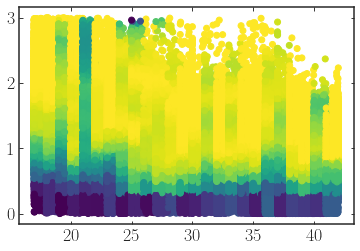

In [32]:
fig, ax=plt.subplots()
ax.scatter(data[400]['spts'], np.log10(data[400]['snrj']), c=data[400]['sl'], cmap='viridis')


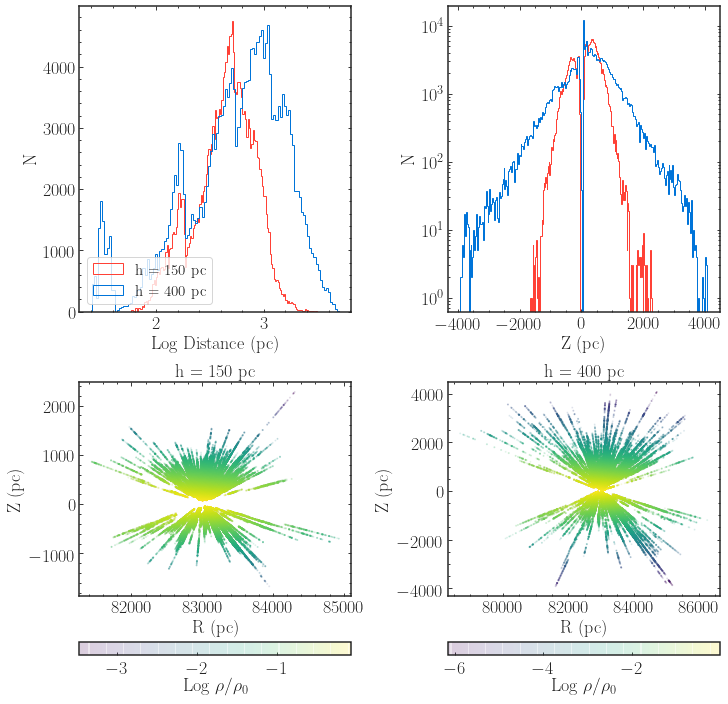

In [33]:
fig, (ax, ax1)=plt.subplots( figsize=(10, 10), ncols=2, nrows=2)

h=ax[0].hist(np.log10(d100.flatten()), color='#FF4136',
          bins='auto', histtype='step', label="h = 150 pc")

h=ax[0].hist(np.log10(d600.flatten()),  color='#0074D9', bins='auto', 
          histtype='step', label="h = 400 pc")


h=ax[1].hist(z100.flatten(), color='#FF4136',
          bins='auto', histtype='step', label="h = 150 pc")

h=ax[1].hist(z600.flatten(),  color='#0074D9', bins='auto', 
          histtype='step', label="h = 400 pc")

c1=ax1[0].scatter(r100, z100, s=1.,  c=np.log10(dens1), cmap='viridis', alpha=0.1)

ax1[0].set_title("h = 150 pc", fontsize=18)
ax1[1].set_title("h = 400 pc", fontsize=18)

c=ax1[1].scatter(r600, z600,s=1.,  c=np.log10(dens2), cmap='viridis', alpha=0.1)

cbar0=plt.colorbar(c, ax=ax1[1],    orientation='horizontal')
cbar1=plt.colorbar(c1, ax=ax1[0],    orientation='horizontal')


cbar0.ax.set_xlabel(r'Log $ \rho/ \rho_0$ ', fontsize=18)
cbar1.ax.set_xlabel(r'Log $ \rho/ \rho_0$ ', fontsize=18)

ax[0].legend(fontsize=15, loc='lower left')
ax[0].set_xlabel('Log Distance (pc)', fontsize=18)
ax[0].set_ylabel('N', fontsize=18)

ax[1].set_xlabel('Z (pc)', fontsize=18)
ax[1].set_ylabel('N', fontsize=18)
ax[1].set_yscale('log')

#ax1[0].legend(fontsize=15, loc='lower left')
ax1[0].set_xlabel('R (pc)', fontsize=18)
ax1[0].set_ylabel('Z (pc)', fontsize=18)

#ax1[1].legend(fontsize=15, loc='lower left')
ax1[1].set_xlabel('R (pc)', fontsize=18)
ax1[1].set_ylabel('Z (pc)', fontsize=18)


for a in np.concatenate([ax, ax1]):
    a.minorticks_on()
    
    
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/simulation_distances.jpeg', bbox_inches='tight', rasterized=True)

In [34]:
maglimits=pd.DataFrame([x.mag_limits for x in pnts])
exposure_times=[np.nanmean(x.exposure_time) for x in pnts]

In [35]:
maglimits['survey']=[x.survey for x in pnts]
maglimits['exp']=np.log10(exposure_times)

In [36]:
#magpolw=wispsim.MAG_LIMITS[survey][][0]
#magpolh=wispsim.MAG_LIMITS[survey][key][0]

#magsctt=MAG_LIMITS[survey][key][1]

#maglt=np.nanmean(np.random.normal(magpol(np.log10(pnt.exposure_time)), magsctt, 100))

In [37]:
import seaborn as sns

In [38]:
wisps_pnts=[x for x in pnts if x.name.startswith('par')]

In [39]:
hst3d_pnts=[x for x in pnts if not x.name.startswith('par')]

In [40]:
pols={'wisps':{}, 'hst3d':{}}

In [41]:
wisps.MAG_LIMITS

{'wisps': {'F110': (poly1d([ 0.38691807, 21.56422243]), 1.3376841296678805),
  'F140': (poly1d([ 1.55375119, 16.85991165]), 0.691598366030491),
  'F160': (poly1d([ 0.9354426, 19.1515984]), 0.9943553416020763)},
 'hst3d': {'F110': (nan, nan),
  'F140': (poly1d([ 0.02900563, 23.5074738 ]), 0.25371284233889885),
  'F160': (poly1d([-0.03135033, 23.63385037]), 0.2573872826293854)}}

In [42]:
pnt_dicts={'wisps':wisps_pnts, 'hst3d':hst3d_pnts}

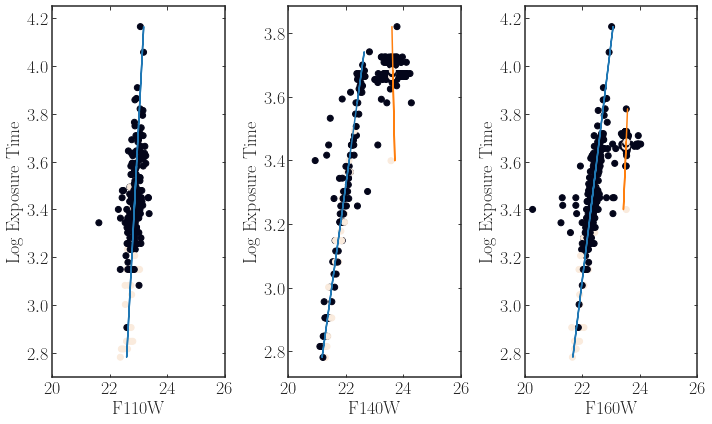

In [43]:
fig, ax=plt.subplots(ncols=3, figsize=(10, 6))

for mag_key, a in zip(['F110', 'F140', 'F160'],ax):
    
    for survey in pnt_dicts.keys():
        
        pts=pnt_dicts[survey]
        
        nsbools=np.array([len(x.mags[mag_key]) for x in pts])
        f110ls=np.array([x.mag_limits[mag_key] for x in pts])
        expts=np.array([np.log10(x.exposure_time) for x in pts ])
        
        nless=nsbools<50
        
        nans=np.isnan(f110ls)

        
        p0=np.nan
        p0_scatter=np.nan
        
        if  len(f110ls[~np.logical_or(nans, nless)]) !=0:
            
            p0=wisps.fit_polynomial( expts[~(nans|nless) ], f110ls[~(nans | nless)], n=1,  sigma_clip=False, sigma=False)
            p0_scatter=np.nanstd( f110ls[~np.logical_or(nans, nless)])
            a.plot(p0(expts[~nans]), expts[~nans])
            
        
        pols[survey][mag_key]=(p0, p0_scatter)
        
        c=a.scatter(f110ls, expts,  c=nless.astype(int).astype(float))
    

    a.set_xlabel(mag_key+'W', fontsize=18)
    a.set_ylabel('Log Exposure Time', fontsize=18)
    a.set_xlim([20, 26])

plt.tight_layout()

In [44]:
pols

{'wisps': {'F110': (poly1d([ 0.42670752, 21.41014841]), 0.19633398957654735),
  'F140': (poly1d([ 1.52318457, 16.93700593]), 0.46360620481210607),
  'F160': (poly1d([ 1.0079978 , 18.87048774]), 0.2807557896001253)},
 'hst3d': {'F110': (nan, nan),
  'F140': (poly1d([-0.23606098, 24.50216826]), 0.23250163972971163),
  'F160': (poly1d([ 0.33923798, 22.27634301]), 0.13330464230127137)}}

In [45]:
#import pickle

#output = open(wisps.OUTPUT_FILES+'/magnitude_cutoff.pkl', 'wb')
#pickle.dump(pols, output)
#output.close()

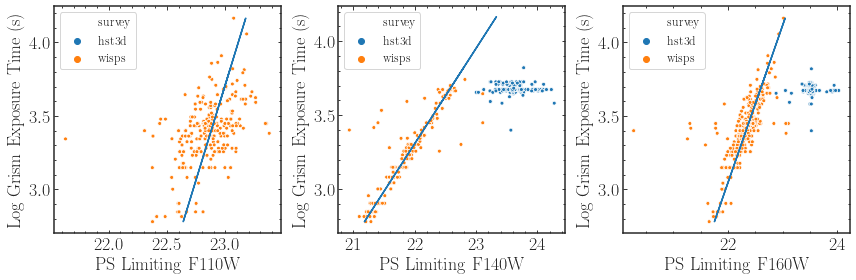

In [46]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))

sns.scatterplot(x='F110', y='exp', hue='survey', s=15., ax=ax[0], data=maglimits)
sns.scatterplot(x='F140', y='exp', hue='survey', s=15., ax=ax[1], data=maglimits)
sns.scatterplot(x='F160', y='exp', hue='survey', s=15., ax=ax[2], data=maglimits)

(ax[0]).plot(((wispsim.MAG_LIMITS['wisps'])['F110'][0])(maglimits.exp),maglimits.exp)
(ax[1]).plot(((wispsim.MAG_LIMITS['wisps'])['F140'][0])(maglimits.exp),maglimits.exp)
(ax[2]).plot(((wispsim.MAG_LIMITS['wisps'])['F160'][0])(maglimits.exp),maglimits.exp)



#(ax[1]).plot(((wispsim.MAG_LIMITS['wisps'])['F140'][0])(maglimits.exp),maglimits.exp)

#(ax[2]).plot(((wispsim.MAG_LIMITS['wisps'])['F160'][0])(maglimits.exp),maglimits.exp)

#ax[1].scatter(maglimits.F140, exposure_times, c='#FF851B', s=15.)
#ax[2].scatter(maglimits.F160, exposure_times, c='#FF4136', s=15.)
for a,k in zip(ax, maglimits.columns):
    #a.set_xlim([20, 25])
    #a.set_yscale('log')
    a.minorticks_on()
    a.set_xlabel('PS Limiting '+ k+'W', fontsize=18)
    a.set_ylabel('Log Grism Exposure Time (s)', fontsize=18)
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/mag_limit.pdf', bbox_inches='tight')

In [47]:
maglimits[maglimits.F160<15.]

,F110,F140,F160,survey,exp


In [166]:
p=pnts[np.random.randint(533)]

In [167]:
p.name

'goodsn-27'

In [168]:
import scipy

In [169]:
vals=p.mags['F160']
vals=vals[~np.isnan(vals)]

In [170]:
len(vals)

182

In [171]:
kde=scipy.stats.gaussian_kde(vals)

In [172]:
frq, edges=np.histogram(vals, bins=int(np.ptp(vals)/0.3), normed=True)

In [173]:
firstd=np.diff(frq, n=1, prepend=frq[0])
sencd=np.diff(firstd, n=1, prepend=firstd[0])

In [174]:
len(edges[: -1]), len(np.gradient(frq)), len(frq), len(firstd)

(33, 33, 33, 33)

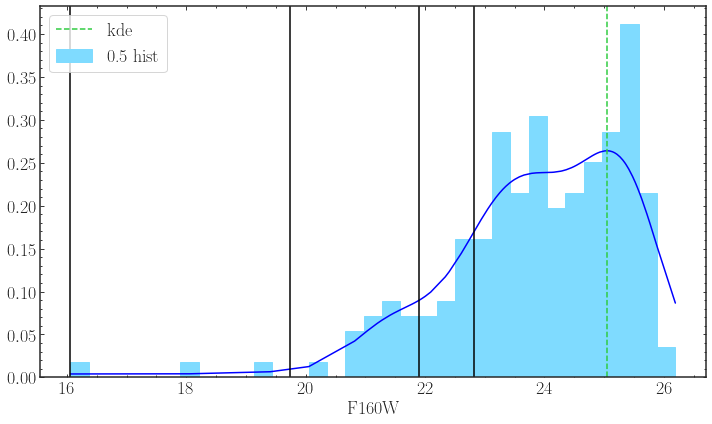

In [175]:
fig, ax=plt.subplots(figsize=(10, 6))
plt.plot(np.sort(vals), kde(np.sort(vals)), c='b')

plt.bar(edges[:-1], frq, width=np.diff(edges), align="edge", label='0.5 hist', color='#7FDBFF', 
        edgecolor='#7FDBFF', fill=True)


plt.axvline(edges[:-1][firstd==0][0], c='k')
plt.axvline(edges[:-1][firstd==0][-3], c='k')
plt.axvline(edges[:-1][firstd==0][-2], c='k')
plt.axvline(edges[:-1][firstd==0][-1], c='k')

#plt.axvline(edges[:-1][np.argmin(sencd)], c='#2ECC40', label='sec')
plt.axvline(vals[np.argmax(kde(vals))], c='#2ECC40', linestyle='--', label='kde')
plt.legend(fontsize=18)
plt.xlabel('F160W', fontsize=18)

plt.minorticks_on()
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/mag_limit_illustration.pdf')

In [176]:
x=np.arange(10).astype(int)

In [177]:
ys=np.random.random(10)

In [178]:
bs=(x==3)

In [179]:
x[bs], ys[bs]

(array([3]), array([0.4370183]))

In [180]:
a=np.empty(23)
a[:]=np.nan

In [181]:
a

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])